In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## part I

In [2]:
df_crsp = pd.read_csv(r"/Users/oliviachen/Downloads/kw4smgwgvkezomgo.csv.gz", na_values=['C'], parse_dates=['date'])

# The output from WRDS returns a mixed of small and large cap column names.
# We can easily convert everything to small caps.
cols = df_crsp.columns
df_crsp.columns = [c.lower() for c in cols]
df_crsp.drop_duplicates(keep='first',inplace=True)
df_crsp.reset_index(inplace=True,drop=True)
df_crsp = df_crsp[df_crsp['exchcd'] == 1.0]
#scd:这个ret导入进来居然是string
df_crsp['ret'] = pd.to_numeric(df_crsp['ret'], errors='coerce')

df_crsp

,permno,date,exchcd,permco,prc,vol,ret,shrout,vwretd,ewretd
0,10006,1926-01-30,1.0,22156,110.250,753.0,0.032732,600.0,0.000561,0.023174
1,10006,1926-02-27,1.0,22156,102.375,342.0,-0.071429,600.0,-0.033046,-0.053510
2,10006,1926-03-31,1.0,22156,96.500,489.0,-0.042735,600.0,-0.064002,-0.096824
3,10006,1926-04-30,1.0,22156,94.000,249.0,-0.025907,600.0,0.037029,0.032975
4,10006,1926-05-28,1.0,22156,96.250,81.0,0.023936,600.0,0.012095,0.001035
...,...,...,...,...,...,...,...,...,...,...
1321571,93172,1974-08-30,1.0,699,5.500,1711.0,-0.371429,2495.0,-0.087757,-0.085788
1321572,93172,1974-09-30,1.0,699,5.000,582.0,-0.090909,2495.0,-0.109718,-0.079025
1321573,93172,1974-10-31,1.0,699,3.125,1137.0,-0.375000,2495.0,0.165584,0.088877
1321574,93172,1974-11-29,1.0,699,2.625,1031.0,-0.160000,2929.0,-0.041046,-0.051395


In [3]:
# 筛选出1926年的数据,这一步是在check有多少上市公司
data_1926 = df_crsp[df_crsp['date'].dt.year == 1926]  
# 根据 permno 去重，统计公司数量
unique_companies = data_1926['permno'].nunique()
unique_companies

565

In [4]:
df_crsp['prc'] = abs(df_crsp['prc'])#取绝对值

df_crsp

,permno,date,exchcd,permco,prc,vol,ret,shrout,vwretd,ewretd
0,10006,1926-01-30,1.0,22156,110.250,753.0,0.032732,600.0,0.000561,0.023174
1,10006,1926-02-27,1.0,22156,102.375,342.0,-0.071429,600.0,-0.033046,-0.053510
2,10006,1926-03-31,1.0,22156,96.500,489.0,-0.042735,600.0,-0.064002,-0.096824
3,10006,1926-04-30,1.0,22156,94.000,249.0,-0.025907,600.0,0.037029,0.032975
4,10006,1926-05-28,1.0,22156,96.250,81.0,0.023936,600.0,0.012095,0.001035
...,...,...,...,...,...,...,...,...,...,...
1321571,93172,1974-08-30,1.0,699,5.500,1711.0,-0.371429,2495.0,-0.087757,-0.085788
1321572,93172,1974-09-30,1.0,699,5.000,582.0,-0.090909,2495.0,-0.109718,-0.079025
1321573,93172,1974-10-31,1.0,699,3.125,1137.0,-0.375000,2495.0,0.165584,0.088877
1321574,93172,1974-11-29,1.0,699,2.625,1031.0,-0.160000,2929.0,-0.041046,-0.051395


In [5]:
from collections import defaultdict

# 假设 new_data 已经加载，并确保 'date' 列是 datetime 类型
df_crsp['date'] = pd.to_datetime(df_crsp['date'])  # 确保日期是datetime格式
#new_data['date'] = pd.to_datetime(new_data['date'])  # 确保日期是datetime格式
# 初始起始年份和月份
start_year = 1926
start_month = 1

# 初始化变量
date = []
valid_firm_number = []
total_number = []
filter_all_data = defaultdict(list)
# 进行16次循环，每次起始时间向后增加3年
for i in range(16):
    sum_valid = 0  # 累计连续85个月的次数
    total_tests = 0  # 总的测试次数
    # 计算当前循环的起始时间
    start_date = pd.Timestamp(year=start_year + i * 3, month=start_month, day=1)
    end_date = start_date + pd.DateOffset(months=85)  # 85个月的截止时间

    #print(f"\n第 {i+1} 次测试: 起始时间 {start_date.date()}")
    date.append(start_date.date())

    # 筛选在当前时间范围内的数据
    need_data = df_crsp.copy(deep=True)
    need_data.dropna(inplace=True)
    filtered_data = need_data[(need_data['date']>= start_date)]
    #filtered_data = new_data[(new_data['date']>= start_date)]
    grouped_data = filtered_data.groupby('permno').filter(lambda x: (x['date'].iloc[0].year == start_date.year) and (x['date'].iloc[0].month == start_date.month))
    grouped_data = grouped_data.groupby('permno')  # 再次按 permno 分组

    # 遍历每个分组，判断前85个月的连续性
    for idx, group in grouped_data:
        total_tests += 1  # 统计总测试次数  

        # 提取当前分组前85个月的数据
        first_85 = group.head(85).copy()
        #print(first_85.head())        
        first_85['year'] = first_85['date'].dt.year
        first_85['month'] = first_85['date'].dt.month
        first_85['month_number'] = (first_85['year'] - first_85['year'].iloc[0]) * 12 + first_85['month']

        # 判断连续性
        first_85['month_diff'] = first_85['month_number'].diff().fillna(1)
        first_85['is_consecutive'] = first_85['month_diff'] == 1

        if first_85['is_consecutive'].all():
            #print(f"permno {idx}: 前85个月的数据是连续的。")
            sum_valid += 1
            filter_all_data[start_date.date()].append(idx)
        #else:
            #print(f"permno {idx}: 前85个月的数据存在中断。")
    valid_firm_number.append(sum_valid)
    total_number.append(total_tests)

# 计算并输出结果
for i in range(16):
    print(f"起始日期:{date[i]},符合要求公司比例: {valid_firm_number[i] / total_number[i]:.2%},符合要求公司总数: {valid_firm_number[i]}, 有效公司总数: {total_number[i]}")

del need_data

起始日期:1926-01-01,符合要求公司比例: 70.91%,符合要求公司总数: 351, 有效公司总数: 495
起始日期:1929-01-01,符合要求公司比例: 72.57%,符合要求公司总数: 455, 有效公司总数: 627
起始日期:1932-01-01,符合要求公司比例: 83.79%,符合要求公司总数: 610, 有效公司总数: 728
起始日期:1935-01-01,符合要求公司比例: 91.51%,符合要求公司总数: 647, 有效公司总数: 707
起始日期:1938-01-01,符合要求公司比例: 96.04%,符合要求公司总数: 751, 有效公司总数: 782
起始日期:1941-01-01,符合要求公司比例: 97.22%,符合要求公司总数: 769, 有效公司总数: 791
起始日期:1944-01-01,符合要求公司比例: 97.91%,符合要求公司总数: 795, 有效公司总数: 812
起始日期:1947-01-01,符合要求公司比例: 99.34%,符合要求公司总数: 902, 有效公司总数: 908
起始日期:1950-01-01,符合要求公司比例: 98.48%,符合要求公司总数: 973, 有效公司总数: 988
起始日期:1953-01-01,符合要求公司比例: 97.80%,符合要求公司总数: 1022, 有效公司总数: 1045
起始日期:1956-01-01,符合要求公司比例: 96.87%,符合要求公司总数: 1020, 有效公司总数: 1053
起始日期:1959-01-01,符合要求公司比例: 95.31%,符合要求公司总数: 1016, 有效公司总数: 1066
起始日期:1962-01-01,符合要求公司比例: 96.23%,符合要求公司总数: 1098, 有效公司总数: 1141
起始日期:1965-01-01,符合要求公司比例: 97.79%,符合要求公司总数: 1196, 有效公司总数: 1223
起始日期:1968-01-01,符合要求公司比例: 98.22%,符合要求公司总数: 1216, 有效公司总数: 1238
起始日期:1971-01-01,符合要求公司比例: 94.21%,符合要求公司总数: 1252, 有效公司总数: 1329


In [6]:
#可以通过如下方式筛选出不同起始点所对应的满足连续85个月都有数值的要求的股票，数字为代码 permno
filter_all_data[pd.to_datetime('1926-01-01').date()]

[10030,
 10049,
 10057,
 10065,
 10081,
 10102,
 10110,
 10129,
 10137,
 10145,
 10188,
 10196,
 10209,
 10217,
 10225,
 10233,
 10241,
 10268,
 10305,
 10313,
 10321,
 10356,
 10364,
 10372,
 10399,
 10401,
 10428,
 10436,
 10444,
 10460,
 10487,
 10495,
 10516,
 10524,
 10559,
 10575,
 10583,
 10591,
 10604,
 10612,
 10647,
 10655,
 10671,
 10698,
 10719,
 10743,
 10751,
 10778,
 10786,
 10794,
 10858,
 10874,
 10890,
 10911,
 10938,
 10946,
 10954,
 10970,
 10989,
 10997,
 11009,
 11025,
 11033,
 11041,
 11068,
 11092,
 11105,
 11113,
 11121,
 11148,
 11156,
 11164,
 11172,
 11199,
 11201,
 11252,
 11260,
 11287,
 11295,
 11308,
 11324,
 11340,
 11359,
 11367,
 11391,
 11404,
 11412,
 11447,
 11463,
 11471,
 11498,
 11500,
 11535,
 11543,
 11551,
 11594,
 11607,
 11615,
 11623,
 11658,
 11666,
 11674,
 11682,
 11690,
 11703,
 11711,
 11746,
 11754,
 11762,
 11789,
 11818,
 11834,
 11850,
 11877,
 11885,
 11914,
 11922,
 11930,
 11949,
 11957,
 11965,
 11973,
 11981,
 12001,
 12028,


In [7]:
df_crsp[df_crsp['ret'] > 1].shape[0]

714

In [8]:
def filter_consecutive_data(date, consecutive_months=84):
    start_date = date - pd.DateOffset(months=consecutive_months)
    return filter_all_data[pd.to_datetime(start_date).date()]

In [9]:
len(filter_consecutive_data(pd.to_datetime('1933-01-01'), consecutive_months=84))

351

## Part II 计算log return 以及benchmark的log return

In [10]:
df_crsp['lret'] = np.log(1 + df_crsp['ret'])
df_crsp['lvwretd'] = np.log(1 + df_crsp['vwretd'])
df_crsp['lewretd'] = np.log(1 + df_crsp['ewretd'])

# Compute the market cap
df_crsp['size'] = df_crsp['shrout'] * df_crsp['prc']

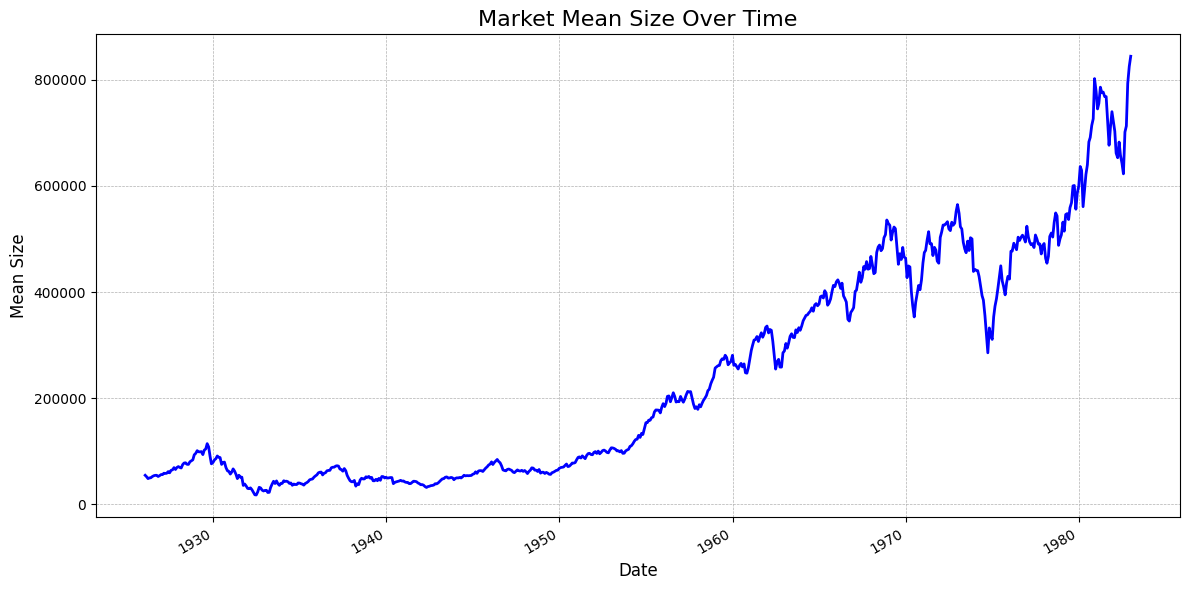

In [11]:
# Calculate and plot the mean size
plt.subplots(figsize=(12, 6))

df_crsp.groupby(['date'])['size'].mean().plot(color='blue', linewidth=2)
# Enhance the plot with grid, intercept, title, and labels
plt.grid(which='both', linestyle='--', linewidth=0.5)

plt.title('Market Mean Size Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean Size', fontsize=12)

# Show plot with enhancements
plt.tight_layout()
plt.show()

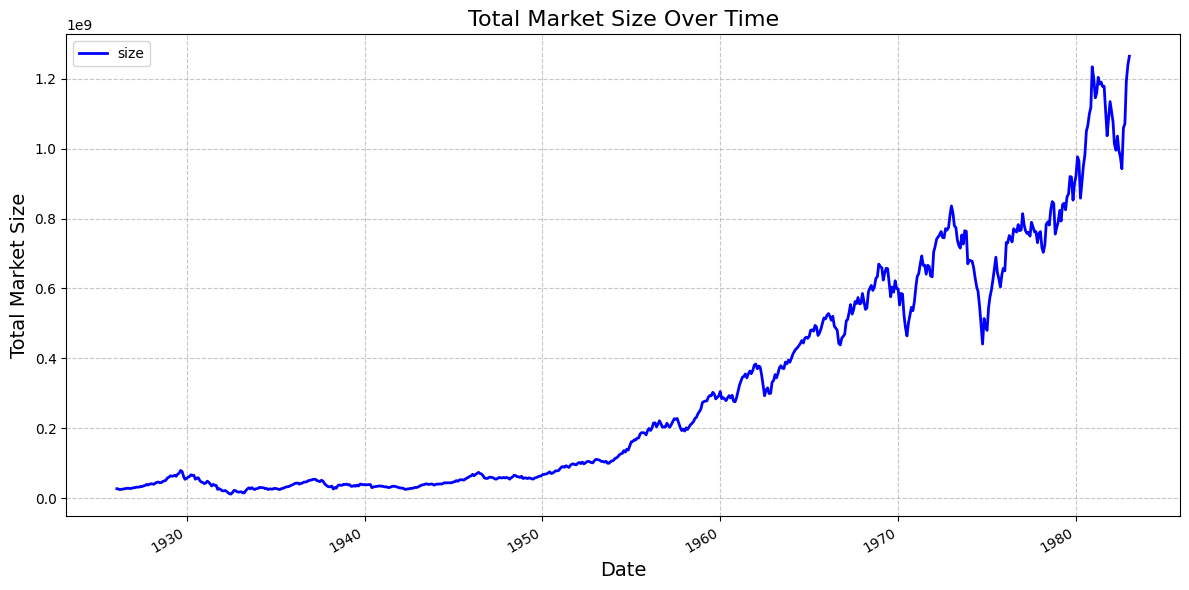

In [14]:
# Plotting total market size over time
fig, ax = plt.subplots(figsize=(12, 6))
df_crsp.groupby(['date'])['size'].sum().plot(color='blue', linewidth=2)

# Enhancing the plot
ax.set_title('Total Market Size Over Time', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Total Market Size', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


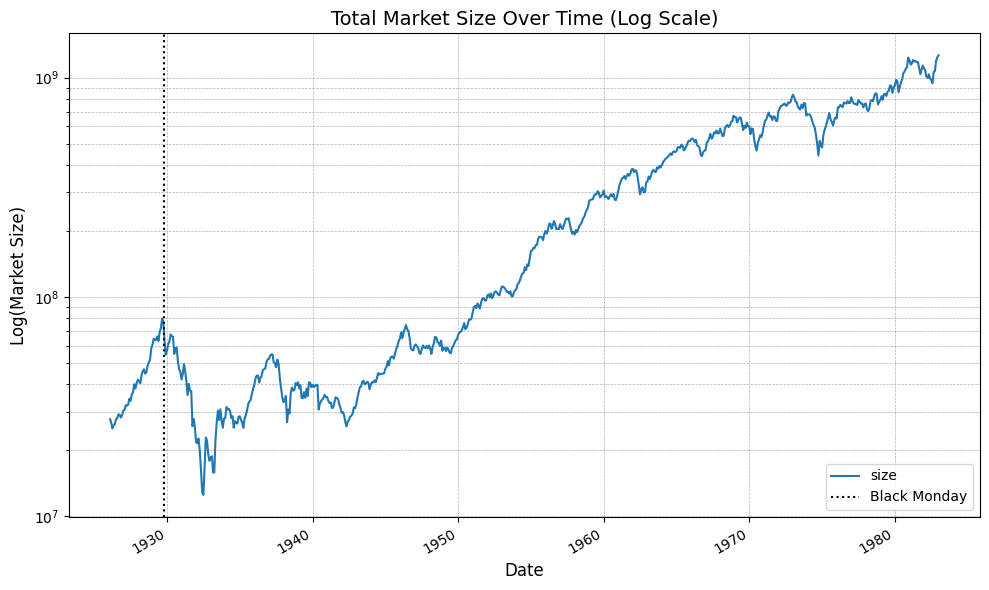

In [15]:

# Plot total market size over time in log scale
fig, ax = plt.subplots(figsize=(10, 6))
df_crsp.groupby(['date'])['size'].sum().plot(logy=True, ax=ax)

# Adding a vertical line for Black Monday
ax.axvline(x=datetime(1929, 10, 24), color='k', linestyle=':', label='Black Monday')

# Enhancing the plot
ax.set_title("Total Market Size Over Time (Log Scale)", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Log(Market Size)", fontsize=12)
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

plt.tight_layout()
plt.show()


## Part II

In [12]:
df_crsp = df_crsp.set_index('date')
df_crsp = df_crsp.sort_index()

In [13]:
form_period = 36
hold_period = 36
use_deciles = True
n_stocks = 35
start_date = '1933-01-01'
end_date = '1978-01-01'
benchmark = 'ewretd'
period_start_dates = pd.date_range(start=start_date, end=end_date, freq=str(int(form_period)) + 'MS')
period_start_dates

DatetimeIndex(['1933-01-01', '1936-01-01', '1939-01-01', '1942-01-01',
               '1945-01-01', '1948-01-01', '1951-01-01', '1954-01-01',
               '1957-01-01', '1960-01-01', '1963-01-01', '1966-01-01',
               '1969-01-01', '1972-01-01', '1975-01-01', '1978-01-01'],
              dtype='datetime64[ns]', freq='36MS')

In [14]:
# 计算36个月formation period，构建top bottom portfolio

def compute_performance_portfolios(hold_date, data, formation_period=36, use_deciles=True, n_stocks=35, benchmark='ewretd'):
    """
    Computes the top and bottom portfolios based on stock performance in the formation period prior to the given date.
    
    Parameters:
        hold_date (datetime): The portfolio hold date.
        data (DataFrame): DataFrame containing stock data with required columns like 'log_return', 'log_market_return', etc.
        formation_period (int): The number of months in the formation period.
        use_deciles (bool): Whether to use decile-based grouping or a fixed number of stocks.
        n_stocks (int): The number of top/bottom stocks if not using deciles.
        benchmark (str): The benchmark column name to compute excess returns.
        
    Returns:
        bottom_portfolio (DataFrame): DataFrame containing bottom portfolio stocks and their excess returns.
        top_portfolio (DataFrame): DataFrame containing top portfolio stocks and their excess returns.
    """
    valid_list = filter_consecutive_data(hold_date, consecutive_months=84)
    # Define the beginning date of the formation period
    start_date = hold_date - pd.DateOffset(months=formation_period)
    # Filter data for the formation period
    formation_data = data[
        (data.index >= start_date) & (data.index <= hold_date.to_pydatetime()) & (data['permno'].isin(valid_list))
        ].copy()
    # Group by stock_id and compute total log returns over the formation period
    stock_returns = formation_data.groupby('permno')[['lret', 'lvwretd', 'lewretd']].sum()
    # Compute excess returns based on the chosen benchmark
    stock_returns['lexret'] = stock_returns['lret'] - stock_returns['l' + benchmark]

    # Compute deciles and rankings for excess returns
    stock_returns['decile'] = pd.qcut(stock_returns['lexret'], 9, labels=False)  # (0 = worst, 9 = best)
    stock_returns['rank_asc'] = stock_returns['lexret'].rank()  # (1 = worst return)
    stock_returns['rank_desc'] = stock_returns['lexret'].rank(ascending=False)  # (1 = best return)

    # Select top and bottom portfolios
    if use_deciles:
        top_portfolio = stock_returns[stock_returns['decile'] == 8].reset_index()[['permno', 'lexret']]
        bottom_portfolio = stock_returns[stock_returns['decile'] == 0].reset_index()[['permno', 'lexret']]
    else:
        top_portfolio = stock_returns[stock_returns['rank_desc'] <= n_stocks].reset_index()[['permno', 'lexret']]
        bottom_portfolio = stock_returns[stock_returns['rank_asc'] <= n_stocks].reset_index()[['permno', 'lexret']]

    return bottom_portfolio, top_portfolio

In [15]:
compute_performance_portfolios(period_start_dates[0],df_crsp,use_deciles=False,n_stocks=10)[1]

,permno,lexret
0,11009,0.897334
1,11498,0.914038
2,11690,1.909926
3,11930,1.206377
4,11949,1.123489
5,13733,1.002342
6,13805,1.137764
7,14314,1.064629
8,14808,2.321336
9,15077,1.066825


In [16]:
portfolios_ten_decile = {}
portfolios_thirtyfive = {}
for date in period_start_dates:
    portfolios_ten_decile[date] = compute_performance_portfolios(date, df_crsp, use_deciles=True, benchmark='ewretd')
    portfolios_thirtyfive[date] = compute_performance_portfolios(date, df_crsp, use_deciles=False, benchmark='ewretd')


得到对于每个16个formation开始时间的top和bottom股票

In [17]:
portfolios_ten_decile[period_start_dates[0]][0].head()

,permno,lexret
0,10049,-2.152940
1,10196,-1.771305
2,10233,-2.106635
3,10460,-1.611452
4,10612,-1.564933


In [18]:
portfolios_thirtyfive[period_start_dates[0]][0].head()

,permno,lexret
0,10049,-2.152940
1,10196,-1.771305
2,10233,-2.106635
3,10460,-1.611452
4,10612,-1.564933


In [19]:
portfolios_thirtyfive[period_start_dates[0]][1].head()

,permno,lexret
0,10225,0.551316
1,10428,0.552555
2,10743,0.846055
3,10970,0.532927
4,10989,0.593758


### Part 3 计算winner/loser portfolio未来的收益并绘图

动态权重版

In [38]:
def calculate_portfolio_returns_modified(date, portfolio, price_data, benchmark_type, weight_type, holding_months):
    end_date = date + pd.offsets.MonthBegin(holding_months)
    period_data = price_data[date.to_pydatetime():end_date].copy()
    stock_data = pd.merge(period_data.reset_index(), portfolio.copy(), on=['permno'])
    date_stock_pairs = [(d, p) for d in stock_data['date'].unique() 
                               for p in portfolio['permno'].unique()]
    complete_pairs = pd.DataFrame(date_stock_pairs, columns=['date', 'permno'])
    stock_data = pd.merge(stock_data, complete_pairs, how='outer', on=['permno', 'date'])
    
    def drop_rows_after_first_nan(data):
        # 找到每组中首次出现 NaN 的索引
        def find_first_nan(group):
            nan_index = group['prc'].isna().idxmax() if group['prc'].isna().any() else None
            return nan_index

        # 按照 permno 分组
        grouped = data.groupby('permno')
        
        # 找到每组中首次出现 NaN 的索引
        nan_indices = grouped.apply(find_first_nan)
        
        # 遍历每组，根据首次 NaN 的索引删除后续行
        def remove_after_nan(group, nan_index):
            if nan_index is not None:
                group = group.loc[:nan_index - 1]
            return group

        def safe_remove_after_nan(group):
            if group.name in nan_indices:
                nan_index = nan_indices[group.name]
            else:
                nan_index = None
            return remove_after_nan(group, nan_index)

        cleaned_data = grouped.apply(safe_remove_after_nan)
        cleaned_data = cleaned_data.reset_index(drop=True)
        return cleaned_data

    new_stock_data = drop_rows_after_first_nan(stock_data)
    
    def calculate_dynamic_weights(data, date):
        # 获取特定日期的有效股票
        date_data = data[data['date'] == date].copy()
        date_data['ew'] = 1.0 / len(date_data)
        date_data['vw'] = date_data['size'] / date_data['size'].sum()
            
        return date_data[['permno', 'ew', 'vw']]
    
    # 对每个日期计算动态权重
    all_weights = []
    for d in new_stock_data['date'].unique():
        weights = calculate_dynamic_weights(new_stock_data, d)
        weights['date'] = d
        all_weights.append(weights)
    
    weights_df = pd.concat(all_weights, ignore_index=True)
    new_stock_data = pd.merge(new_stock_data, weights_df, on=['date', 'permno'], how='left')
    
    # 选择第一个股票的permno
    first_permno = new_stock_data['permno'].iloc[0]
    print(f"\nSample of dynamic weights for stock {first_permno} across different dates:")
    print(new_stock_data[new_stock_data['permno'] == first_permno][['date', 'permno', 'size', 'ew', 'vw']].head())

    print(f"\nWeights validation for selected dates of stock {first_permno}:")
    stock_data = new_stock_data[new_stock_data['permno'] == first_permno].head()
    for date in stock_data['date'].unique():
        date_total = new_stock_data[new_stock_data['date'] == date]
        print(f"\nDate: {date}")
        print(f"Number of stocks on this date: {len(date_total)}")
        print(f"Sum of EW weights: {date_total['ew'].sum():.4f}")
        print(f"Sum of VW weights: {date_total['vw'].sum():.4f}")




    def calculate_AR_CAR(stock_data, benchmark):
        
        stock_data['weighted_ret'] = stock_data[weight_type] * stock_data['ret']
        stock_data[f'weighted_benchmark'] = stock_data[weight_type] * stock_data[benchmark]
        
        
        portfolio_returns = stock_data.groupby('date')[['weighted_ret', 'weighted_benchmark']].sum()
        portfolio_returns = portfolio_returns.reset_index()
        portfolio_returns['months'] = range(1, len(portfolio_returns) + 1)
        

        portfolio_returns['AR'] = (portfolio_returns['weighted_ret'] - 
                                 portfolio_returns['weighted_benchmark'])
        portfolio_returns['CAR'] = portfolio_returns['AR'].cumsum()
        
        return portfolio_returns[['months', 'AR', 'CAR']]
    
    return calculate_AR_CAR(new_stock_data, benchmark_type)

def compute_portfolio_performance_modified(start_dates, portfolios, price_data, benchmark_type, weight_type, holding_months):
    bottom_returns = []
    top_returns = []
    
    for date in start_dates:
        bottom_returns.append(
            calculate_portfolio_returns_modified(
                date,
                portfolios[date][0],
                price_data,
                benchmark_type, 
                weight_type, 
                holding_months
            )
        )
    
        top_returns.append(
            calculate_portfolio_returns_modified(
                date,
                portfolios[date][1],
                price_data,
                benchmark_type, 
                weight_type, 
                holding_months
            )
        )
    
    bottom_returns = pd.concat(bottom_returns, ignore_index=True)
    top_returns = pd.concat(top_returns, ignore_index=True)
    
    # Add starting point (0,0) for CAR
    zero_point = pd.DataFrame({'months': [0], 'AR': [0], 'CAR': [0]})
    
    # Group by 'months' and calculate mean for AR and CAR directly
    bottom_mean = bottom_returns.groupby('months')[['AR', 'CAR']].mean().reset_index()
    top_mean = top_returns.groupby('months')[['AR', 'CAR']].mean().reset_index()
    
    # Combine with zero point for final output
    bottom_final = pd.concat([zero_point, bottom_mean], ignore_index=True)
    top_final = pd.concat([zero_point, top_mean], ignore_index=True)
    
    return bottom_final, top_final

权重没有修改版

In [23]:
#权重部分待修改
def calculate_portfolio_returns_modified(date, portfolio, price_data, benchmark_type, weight_type, holding_months):
    
    end_date = date + pd.offsets.MonthBegin(holding_months)
    period_data = price_data[date.to_pydatetime():end_date].copy()
    stock_data = pd.merge(period_data.reset_index(), portfolio.copy(), on=['permno'])
    date_stock_pairs = [(d, p) for d in stock_data['date'].unique() 
                               for p in portfolio['permno'].unique()]
    complete_pairs = pd.DataFrame(date_stock_pairs, columns=['date', 'permno'])
    stock_data = pd.merge(stock_data, complete_pairs, how='outer', on=['permno', 'date'])
    
    # Handle missing returns
    return_columns = ['ret', 'vwretd', 'ewretd', 'lvwretd', 'lewretd', 'lret', 'lexret']

    def drop_rows_after_first_nan(data):
    # 找到每组中首次出现 NaN 的索引
        def find_first_nan(group):
            nan_index = group['prc'].isna().idxmax() if group['prc'].isna().any() else None
            return nan_index

        # 按照 permno 分组
        grouped = data.groupby('permno')

        # 找到每组中首次出现 NaN 的索引
        nan_indices = grouped.apply(find_first_nan)

        # 遍历每组，根据首次 NaN 的索引删除后续行
        def remove_after_nan(group, nan_index):
            if nan_index is not None:
                group = group.loc[:nan_index - 1]
            return group

        def safe_remove_after_nan(group):
            # 检查 nan_indices 是否包含当前组名
            if group.name in nan_indices:
                nan_index = nan_indices[group.name]
            else:
                nan_index = None
            return remove_after_nan(group, nan_index)

        cleaned_data = grouped.apply(safe_remove_after_nan)
        # 去掉多余的分组索引
        cleaned_data = cleaned_data.reset_index(drop=True)

        return cleaned_data

    # 根据nan进行过组合筛选
    new_stock_data = drop_rows_after_first_nan(stock_data)

    #权重这里有点奇怪，可能需要修改
    def calculate_weights(portfolio, price_data, date):
        weights = portfolio.copy()
        weights['ew'] = 1.0 / len(portfolio)
        weights['date'] = date
        market_cap = pd.merge_asof(weights, 
                                 price_data[['permno', 'size']],
                                 by='permno',
                                 left_on='date',
                                 right_index=True)
        
        market_cap['vw'] = market_cap['size'] / market_cap['size'].sum()
        return market_cap[['permno', 'ew', 'vw']]
    
    weights = calculate_weights(portfolio, price_data, date)
    new_stock_data = pd.merge(new_stock_data, weights, on='permno')

    def calculate_AR_CAR(stock_data,benchmark):
        #first calcultae AR
        stock_data[f'weighted_ret'] = stock_data[weight_type] * stock_data['ret']
        stock_data[f'weighted_benchmark'] = stock_data[weight_type] * stock_data[benchmark]
    
        portfolio_returns = stock_data.groupby('date')[[f'weighted_ret', f'weighted_benchmark']].sum()
        
        
        portfolio_returns = portfolio_returns.reset_index()
        portfolio_returns['months'] = range(1, len(portfolio_returns) + 1)
        portfolio_returns['AR'] = (portfolio_returns[f'weighted_ret'] - 
                                            portfolio_returns[f'weighted_benchmark'])
        #then use AR to calculate CAR
        portfolio_returns['CAR'] = portfolio_returns['AR'].cumsum()

        return portfolio_returns[['months', 'AR','CAR']]
        
    return calculate_AR_CAR(new_stock_data,benchmark_type)

def compute_portfolio_performance_modified(start_dates, portfolios, price_data, benchmark_type, weight_type,holding_months):
    bottom_returns = []
    top_returns = []
    
    for date in start_dates:
        bottom_returns.append(
                calculate_portfolio_returns_modified(
                date,
                portfolios[date][0],
                price_data,
                benchmark_type, 
                weight_type, 
                holding_months
            )
        )
    
        top_returns.append(
                calculate_portfolio_returns_modified(
                date,
                portfolios[date][1],
                price_data,
                benchmark_type, 
                weight_type, 
                holding_months
            )
        )
    
    bottom_returns = pd.concat(bottom_returns, ignore_index=True)
    top_returns = pd.concat(top_returns, ignore_index=True)
    
    # Add starting point (0,0) for CAR
    zero_point = pd.DataFrame({'months': [0], 'AR': [0], 'CAR': [0]})
    
    # Group by 'months' and calculate mean for AR and CAR directly
    bottom_mean = bottom_returns.groupby('months')[['AR', 'CAR']].mean().reset_index()
    top_mean = top_returns.groupby('months')[['AR', 'CAR']].mean().reset_index()
    
    # Combine with zero point for final output
    bottom_final = pd.concat([zero_point, bottom_mean], ignore_index=True)
    top_final = pd.concat([zero_point, top_mean], ignore_index=True)
    
    return bottom_final, top_final

In [23]:
calculate_portfolio_returns_modified(
                period_start_dates[2],
                portfolios_thirtyfive[period_start_dates[2]][0],
                df_crsp,
                'vwretd','vw',36)


Sample of dynamic weights for stock 10858 across different dates:
        date  permno    size        ew        vw
0 1939-01-31   10858  8464.0  0.031250  0.091443
1 1939-02-28   10858  9200.0  0.031250  0.097876
2 1939-03-31   10858  5704.0  0.031250  0.080133
3 1939-04-29   10858  7820.0  0.032258  0.105964
4 1939-05-31   10858  8602.0  0.033333  0.105934

Weights validation for selected dates of stock 10858:

Date: 1939-01-31 00:00:00
Number of stocks on this date: 32
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Date: 1939-02-28 00:00:00
Number of stocks on this date: 32
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Date: 1939-03-31 00:00:00
Number of stocks on this date: 32
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Date: 1939-04-29 00:00:00
Number of stocks on this date: 31
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Date: 1939-05-31 00:00:00
Number of stocks on this date: 30
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000


,months,AR,CAR
0,1,0.021374,0.021374
1,2,-0.013631,0.007743
2,3,-0.114014,-0.106271
3,4,0.054943,-0.051328
4,5,0.046547,-0.004781
5,6,-0.065274,-0.070055
6,7,0.230008,0.159953
7,8,-0.104400,0.055553
8,9,0.661544,0.717097
9,10,-0.071061,0.646036


In [25]:
calculate_portfolio_returns_modified(
                period_start_dates[5],
                portfolios_thirtyfive[period_start_dates[5]][0],
                df_crsp,
                'vwretd','vw',36)


Sample of dynamic weights for stock 10014 across different dates:
        date  permno      size        ew        vw
0 1948-01-31   10014  5948.000  0.028571  0.007178
1 1948-02-28   10014  5762.125  0.028571  0.007507
2 1948-03-31   10014  5576.250  0.028571  0.006617
3 1948-04-30   10014  5390.375  0.028571  0.006359
4 1948-05-28   10014  5948.000  0.028571  0.006298

Weights validation for selected dates of stock 10014:

Date: 1948-01-31 00:00:00
Number of stocks on this date: 35
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Date: 1948-02-28 00:00:00
Number of stocks on this date: 35
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Date: 1948-03-31 00:00:00
Number of stocks on this date: 35
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Date: 1948-04-30 00:00:00
Number of stocks on this date: 35
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Date: 1948-05-28 00:00:00
Number of stocks on this date: 35
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000


,months,AR,CAR
0,1,0.078446,0.078446
1,2,-0.027161,0.051284
2,3,0.030435,0.081719
3,4,-0.024251,0.057469
4,5,0.046324,0.103793
5,6,-0.006274,0.097519
6,7,0.005485,0.103003
7,8,-0.001284,0.101720
8,9,-0.009748,0.091971
9,10,-0.005781,0.086190


In [39]:
bottom_returns_TEST, top_returns_TEST = compute_portfolio_performance_modified(
     period_start_dates, 
     portfolios_thirtyfive, 
     df_crsp,'vwretd','vw',36)

bottom_returns_TEST2, top_returns_TEST2 = compute_portfolio_performance_modified(
     period_start_dates, 
     portfolios_thirtyfive, 
     df_crsp,'ewretd','ew',36)


Sample of dynamic weights for stock 10196 across different dates:
        date  permno     size        ew        vw
0 1933-01-31   10196  11960.0  0.033333  0.138376
1 1933-02-28   10196   8280.0  0.034483  0.131797
2 1933-03-31   10196   7590.0  0.035714  0.116056
3 1933-04-29   10196  17480.0  0.035714  0.141521
4 1933-05-31   10196  22540.0  0.037037  0.116320

Weights validation for selected dates of stock 10196:

Date: 1933-01-31 00:00:00
Number of stocks on this date: 30
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Date: 1933-02-28 00:00:00
Number of stocks on this date: 29
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Date: 1933-03-31 00:00:00
Number of stocks on this date: 28
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Date: 1933-04-29 00:00:00
Number of stocks on this date: 28
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Date: 1933-05-31 00:00:00
Number of stocks on this date: 27
Sum of EW weights: 1.0000
Sum of VW weights: 1.0000

Sample of dy

In [26]:
#看一下长啥样
bottom_returns_TEST

,months,AR,CAR
0,0,0.000000,0.000000
1,1,0.105977,0.105977
2,2,-0.008615,0.097362
3,3,0.007357,0.104719
4,4,0.026383,0.131102
5,5,0.044805,0.175907
6,6,0.005355,0.181263
7,7,0.023969,0.205232
8,8,-0.005115,0.200116
9,9,0.044863,0.244980


In [33]:
#新的画图代码
def draw_CAR_pictures_modified(bottom_returns,top_returns,weight):
    plt.figure(figsize=(8, 6))
    plt.plot(bottom_returns['months'], bottom_returns['CAR'],
            label='Loser Portfolio',
            color='black',
            linestyle='-',
            marker='o',
            markersize=4)

    plt.plot(top_returns['months'], top_returns['CAR'],
            label='Winner Portfolio',
            color='black',
            linestyle='--',
            marker='x',
            markersize=4)

    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

    plt.title(f'Cumulative Average Residuals for Winner and Loser Portfolios - {weight}', fontsize=12)
    plt.xlabel('MONTHS AFTER PORTFOLIO FORMATION', fontsize=10)
    plt.ylabel('CAR', fontsize=10)

    plt.xticks(fontsize=8)
    plt.yticks(np.arange(-0.1, 0.3, 0.05))

    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

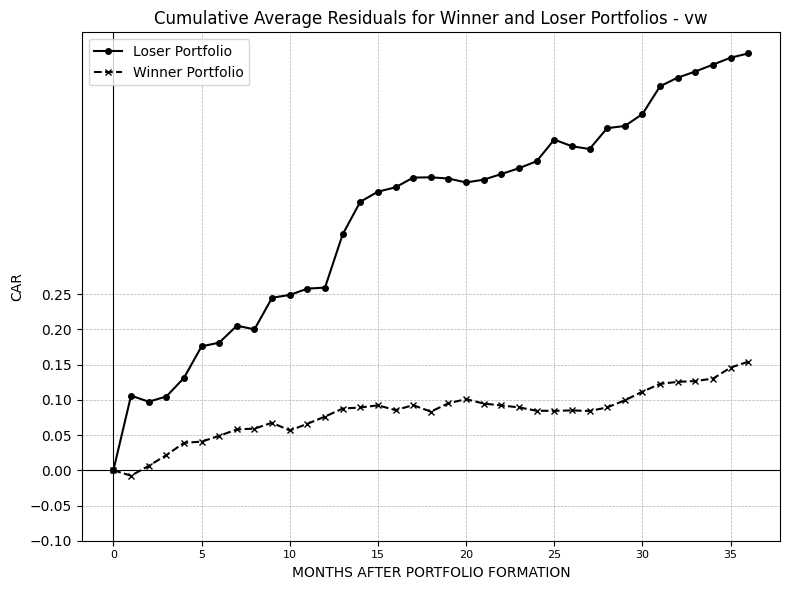

In [40]:
#TEST由用我加的代码计算得出
draw_CAR_pictures_modified(bottom_returns_TEST,top_returns_TEST,'vw')

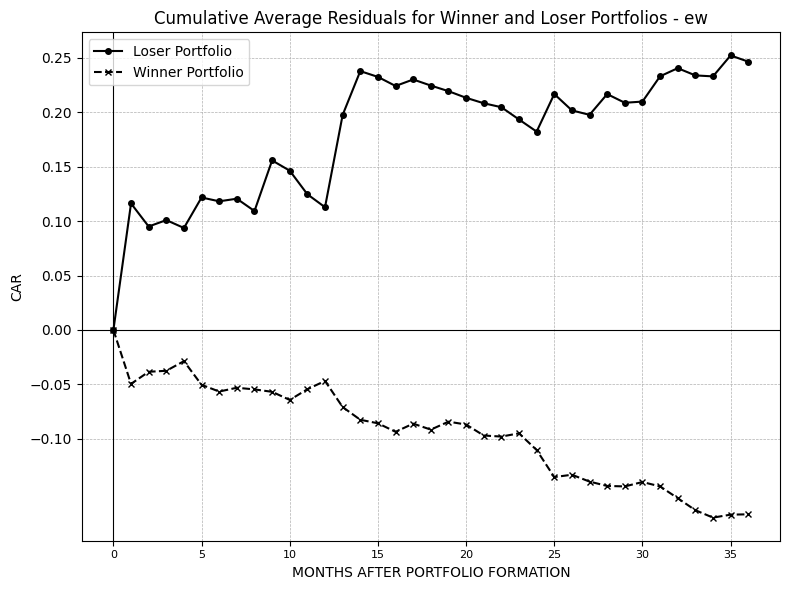

In [41]:
draw_CAR_pictures_modified(bottom_returns_TEST2,top_returns_TEST2,'ew')

### 假设检验

In [34]:
bottom_returns_TEST.drop(index=0,inplace=True)
bottom_returns_TEST.reset_index(drop=True,inplace=True)
top_returns_TEST.drop(index=0,inplace=True)
top_returns_TEST.reset_index(drop=True,inplace=True)

In [35]:
def calculate_s_and_t(period_start_dates, portfolios, price_data, benchmark_type, weight_type, holding_months, average_ar_car_bottom, average_ar_car_top):
    # 样本数
    num_experiments = len(period_start_dates)
    # 存储每个时间点的 S_t^2
    pooled_variance_sum_bottom = pd.DataFrame(np.zeros_like(average_ar_car_bottom[['AR','CAR']]),columns=['AR','CAR'])
    pooled_variance_sum_top = pd.DataFrame(np.zeros_like(average_ar_car_top[['AR','CAR']]),columns=['AR','CAR'])

    for date in period_start_dates:
        # 计算单次实验的bottom和top
        bottom_single_AR_CAR = calculate_portfolio_returns_modified(
            date,
            portfolios[date][0],
            price_data,
            benchmark_type,
            weight_type,
            holding_months
        )
        top_single_AR_CAR = calculate_portfolio_returns_modified(
            date,
            portfolios[date][1],
            price_data,
            benchmark_type,
            weight_type,
            holding_months
        )

        # 计算差值
        minus_AR_CAR_bottom = (bottom_single_AR_CAR[['AR', 'CAR']] - average_ar_car_bottom[['AR', 'CAR']])**2
        minus_AR_CAR_top = (top_single_AR_CAR[['AR', 'CAR']] - average_ar_car_top[['AR', 'CAR']])**2

        pooled_variance_sum_bottom = pooled_variance_sum_bottom + minus_AR_CAR_bottom
        pooled_variance_sum_top = pooled_variance_sum_top + minus_AR_CAR_top

    pooled_variance_car = (pooled_variance_sum_bottom + pooled_variance_sum_top)/ (2 * (num_experiments - 1))  # 公式中除以 2(N-1)
    acar_diff = average_ar_car_bottom['CAR'] - average_ar_car_top['CAR']

    pooled_variance_ar_bottom = np.sqrt(pooled_variance_sum_bottom['AR']/(num_experiments - 1))
    pooled_variance_ar_top = np.sqrt(pooled_variance_sum_top['AR']/(num_experiments - 1))

    # 计算 t 统计量
    t_statistic_car = pd.DataFrame(acar_diff / np.sqrt(2 * pooled_variance_car['CAR'] / num_experiments))
    t_statistic_car = t_statistic_car.rename(columns={'CAR':'t-statistics'})
    t_statistic_car.index = t_statistic_car.index + 1 
    t_statistic_car.index.name = 'month'  

    t_statistic_bottom_ar = pd.DataFrame(average_ar_car_bottom['AR'] / (pooled_variance_ar_bottom / np.sqrt(num_experiments)))
    t_statistic_bottom_ar = t_statistic_bottom_ar.rename(columns={'AR':'loser-AR t-statistics'})
    t_statistic_bottom_ar.index = t_statistic_bottom_ar.index + 1  
    t_statistic_bottom_ar.index.name = 'month'  

    t_statistic_top_ar = pd.DataFrame(average_ar_car_top['AR'] / (pooled_variance_ar_top / np.sqrt(num_experiments)))
    t_statistic_top_ar = t_statistic_top_ar.rename(columns={'AR':'winner-AR t-statistics'})
    t_statistic_top_ar.index = t_statistic_top_ar.index + 1  
    t_statistic_top_ar.index.name = 'month'  
    return t_statistic_car,t_statistic_bottom_ar,t_statistic_top_ar

In [36]:
car_t,ar_loser_t,ar_winner_t = calculate_s_and_t(period_start_dates, portfolios_thirtyfive,df_crsp,'vwretd','vw',36, bottom_returns_TEST, top_returns_TEST)

In [37]:
car_t

,t-statistics
month,
1,2.750359
2,1.774850
3,1.292044
4,1.211847
5,1.441328
6,1.271372
7,1.453215
8,1.316570
9,1.697241


In [38]:
ar_loser_t

,loser-AR t-statistics
month,
1,2.657983
2,-1.643383
3,-0.021986
4,0.393297
5,1.188899
6,-0.148237
7,1.033427
8,-1.001672
9,0.859438


In [39]:
ar_winner_t

,winner-AR t-statistics
month,
1,-0.808657
2,1.068542
3,1.215830
4,0.907999
5,-0.306730
6,0.038861
7,0.543528
8,-0.312947
9,0.068255
